In [0]:
#@title Copyright 2019 The Lifetime Value Authors.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================

# Lifetime Value prediction for Kaggle Acquire Valued Customer Challenge

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/lifetime_value/blob/master/notebooks/kaggle_acquire_valued_shoppers_challenge/regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/lifetime_value/blob/master/notebooks/kaggle_acquire_valued_shoppers_challenge/regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [0]:


import os

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn import model_selection
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import tensorflow_probability as tfp
import tqdm
from typing import Sequence

# install and import ltv
!pip install -q git+https://github.com/google/lifetime_value
import lifetime_value as ltv

In [0]:
tfd = tfp.distributions
tf.enable_eager_execution()
%config InlineBackend.figure_format='retina'
sns.set_style('whitegrid')
pd.options.mode.chained_assignment = None  # default='warn'

## Global variables

In [0]:
COMPANY = '103600030'  # @param { isTemplate: true, type: 'string'}
LOSS = 'ziln'  # @param { isTemplate: true, type: 'string'} ['mse', 'ziln']
MODEL = 'dnn'  # @param { isTemplate: true, type: 'string'} ['linear', 'dnn']
LEARNING_RATE = 0.0002  # @param { isTemplate: true}
EPOCHS = 400  # @param { isTemplate: true, type: 'integer'}
OUTPUT_CSV_FOLDER = '/tmp/lifetime-value/kaggle_acquire_valued_shoppers_challenge/result'  # @param { isTemplate: true, type: 'string'}

In [0]:
CATEGORICAL_FEATURES = ['chain', 'dept', 'category', 'brand', 'productmeasure']
NUMERIC_FEATURES = ['log_calibration_value']

ALL_FEATURES = CATEGORICAL_FEATURES + NUMERIC_FEATURES

## Data

### Download data

Setup kaggle API correctly following https://www.kaggle.com/docs/api

In [0]:
%%shell
if [ -e /tmp/lifetime-value/acquire-valued-shoppers-challenge/transactions.csv ]
then
  echo "File already exists, no need to download."
else
  rm -rf /tmp/lifetime-value/acquire-valued-shoppers-challenge
  mkdir /tmp/lifetime-value/acquire-valued-shoppers-challenge
  cd /tmp/lifetime-value/acquire-valued-shoppers-challenge
  kaggle competitions download -c acquire-valued-shoppers-challenge
  unzip acquire-valued-shoppers-challenge.zip
  gunzip transactions.csv.gz
fi

File already exists, no need to download.


### Load transaction csv

In [0]:
def load_transaction_data(company):
  all_data_filename = '/tmp/lifetime-value/acquire-valued-shoppers-challenge/transactions.csv'
  one_company_data_filename = (
      '/tmp/lifetime-value/acquire-valued-shoppers-challenge/transactions_company_{}.csv'
      .format(COMPANY))
  if os.path.isfile(one_company_data_filename):
    df = pd.read_csv(one_company_data_filename)
  else:
    data_list = []
    chunksize = 10**6
    # 350 iterations
    for chunk in tqdm.tqdm(pd.read_csv(all_data_filename, chunksize=chunksize)):
      data_list.append(chunk.query("company=='{}'".format(company)))
    df = pd.concat(data_list, axis=0)
    df.to_csv(one_company_data_filename, index=None)
  return df

### Preprocess data

In [0]:
def preprocess(df):
  df = df.query('purchaseamount>0')
  df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
  df['start_date'] = df.groupby('id')['date'].transform('min')

  # Compute calibration values
  calibration_value = (
      df.query('date==start_date').groupby('id')
      ['purchaseamount'].sum().reset_index())
  calibration_value.columns = ['id', 'calibration_value']

  # Compute holdout values
  one_year_holdout_window_mask = (
      (df['date'] > df['start_date']) &
      (df['date'] <= df['start_date'] + np.timedelta64(365, 'D')))
  holdout_value = (
      df[one_year_holdout_window_mask].groupby('id')
      ['purchaseamount'].sum().reset_index())
  holdout_value.columns = ['id', 'holdout_value']

  # Compute calibration attributes
  calibration_attributes = (
      df.query('date==start_date').sort_values(
          'purchaseamount', ascending=False).groupby('id')[[
              'chain', 'dept', 'category', 'brand', 'productmeasure'
          ]].first().reset_index())

  # Merge dataframes
  customer_level_data = (
      calibration_value.merge(calibration_attributes, how='left',
                              on='id').merge(
                                  holdout_value, how='left', on='id'))
  customer_level_data['holdout_value'] = (
      customer_level_data['holdout_value'].fillna(0.))
  customer_level_data[CATEGORICAL_FEATURES] = (
      customer_level_data[CATEGORICAL_FEATURES].fillna('UNKNOWN'))

  # Specify data types
  customer_level_data['log_calibration_value'] = (
      np.log(customer_level_data['calibration_value']).astype('float32'))
  customer_level_data['chain'] = (
      customer_level_data['chain'].astype('category'))
  customer_level_data['dept'] = (customer_level_data['dept'].astype('category'))
  customer_level_data['brand'] = (
      customer_level_data['brand'].astype('category'))
  customer_level_data['category'] = (
      customer_level_data['category'].astype('category'))
  customer_level_data['label'] = (
      customer_level_data['holdout_value'].astype('float32'))
  return customer_level_data

### Load customer-level csv

In [0]:
def load_customer_level_csv(company):
  customer_level_data_file = (
      '/tmp/lifetime-value/acquire-valued-shoppers-challenge/customer_level_data_company_{}.csv'
      .format(company))
  if os.path.isfile(customer_level_data_file):
    customer_level_data = pd.read_csv(customer_level_data_file)
  else:
    customer_level_data = preprocess(load_transaction_data(company))
  for cat_col in CATEGORICAL_FEATURES:
    customer_level_data[cat_col] = (
        customer_level_data[cat_col].astype('category'))
  for num_col in [
      'log_calibration_value', 'calibration_value', 'holdout_value'
  ]:
    customer_level_data[num_col] = (
        customer_level_data[num_col].astype('float32'))

  return customer_level_data

In [0]:
customer_level_data = load_customer_level_csv(COMPANY)

We observe a mixture of zero and lognormal distribution of holdout value.

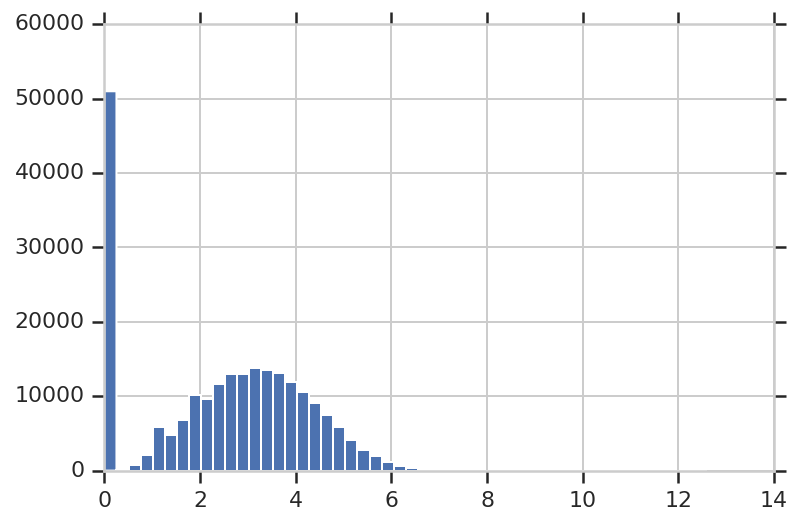

In [0]:
customer_level_data.label.apply(np.log1p).hist(bins=50)

### Make train/eval

In [0]:
def linear_split(df):
  # get_dummies preserves numeric features.
  x = pd.get_dummies(df[ALL_FEATURES], drop_first=True).astype('float32').values
  y = df['label'].values
  y0 = df['calibration_value'].values

  x_train, x_eval, y_train, y_eval, y0_train, y0_eval = (
      model_selection.train_test_split(
          x, y, y0, test_size=0.2, random_state=123))

  return x_train, x_eval, y_train, y_eval, y0_eval

In [0]:
def dnn_split(df):
  for key in CATEGORICAL_FEATURES:
    encoder = preprocessing.LabelEncoder()
    df[key] = encoder.fit_transform(df[key])

  y0 = df['calibration_value'].values
  df_train, df_eval, y0_train, y0_eval = model_selection.train_test_split(
      df, y0, test_size=0.2, random_state=123)

  def feature_dict(df):
    features = {k: v.values for k, v in dict(df[CATEGORICAL_FEATURES]).items()}
    features['numeric'] = df[NUMERIC_FEATURES].values
    return features

  x_train, y_train = feature_dict(df_train), df_train['label'].values
  x_eval, y_eval = feature_dict(df_eval), df_eval['label'].values

  return x_train, x_eval, y_train, y_eval, y0_eval

## Model

In [0]:
def linear_model(output_units):
  return tf.keras.experimental.LinearModel(output_units)

In [0]:
def embedding_dim(x):
  return int(x**.25) + 1


def embedding_layer(vocab_size):
  return tf.keras.Sequential([
      tf.keras.layers.Embedding(
          input_dim=vocab_size,
          output_dim=embedding_dim(vocab_size),
          input_length=1),
      tf.keras.layers.Flatten(),
  ])


def dnn_model(output_units, df):
  numeric_input = tf.keras.layers.Input(
      shape=(len(NUMERIC_FEATURES),), name='numeric')

  embedding_inputs = [
      tf.keras.layers.Input(shape=(1,), name=key, dtype=np.int64)
      for key in CATEGORICAL_FEATURES
  ]

  embedding_outputs = [
      embedding_layer(vocab_size=df[key].nunique())(input)
      for key, input in zip(CATEGORICAL_FEATURES, embedding_inputs)
  ]

  deep_input = tf.keras.layers.concatenate([numeric_input] + embedding_outputs)
  deep_model = tf.keras.Sequential([
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(output_units),
  ])
  return tf.keras.Model(
      inputs=[numeric_input] + embedding_inputs, outputs=deep_model(deep_input))

### Train

In [0]:
if LOSS == 'mse':
  loss = keras.losses.MeanSquaredError()
  output_units = 1

if LOSS == 'ziln':
  loss = ltv.zero_inflated_lognormal_loss
  output_units = 3

In [0]:
if MODEL == 'linear':
  x_train, x_eval, y_train, y_eval, y0_eval = linear_split(customer_level_data)
  model = linear_model(output_units)

if MODEL == 'dnn':
  x_train, x_eval, y_train, y_eval, y0_eval = dnn_split(customer_level_data)
  model = dnn_model(output_units, customer_level_data)

In [0]:
model.compile(loss=loss, optimizer=keras.optimizers.Adam(lr=LEARNING_RATE))

In [0]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=1e-6),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
]

In [0]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=1024,
    epochs=EPOCHS,
    verbose=2,
    callbacks=callbacks,
    validation_data=(x_eval, y_eval)).history

Train on 180145 samples, validate on 45037 samples
Epoch 1/400
180145/180145 - 2s - loss: 7.0981 - val_loss: 5.3484
Epoch 2/400
180145/180145 - 1s - loss: 4.7133 - val_loss: 4.4211
Epoch 3/400
180145/180145 - 1s - loss: 4.2896 - val_loss: 4.2134
Epoch 4/400
180145/180145 - 1s - loss: 4.1925 - val_loss: 4.1868
Epoch 5/400
180145/180145 - 1s - loss: 4.1803 - val_loss: 4.1819
Epoch 6/400
180145/180145 - 1s - loss: 4.1772 - val_loss: 4.1803
Epoch 7/400
180145/180145 - 1s - loss: 4.1759 - val_loss: 4.1794
Epoch 8/400
180145/180145 - 1s - loss: 4.1750 - val_loss: 4.1788
Epoch 9/400
180145/180145 - 1s - loss: 4.1741 - val_loss: 4.1779
Epoch 10/400
180145/180145 - 1s - loss: 4.1732 - val_loss: 4.1771
Epoch 11/400
180145/180145 - 1s - loss: 4.1723 - val_loss: 4.1764
Epoch 12/400
180145/180145 - 1s - loss: 4.1714 - val_loss: 4.1757
Epoch 13/400
180145/180145 - 1s - loss: 4.1708 - val_loss: 4.1750
Epoch 14/400
180145/180145 - 1s - loss: 4.1702 - val_loss: 4.1748
Epoch 15/400
180145/180145 - 1s - 

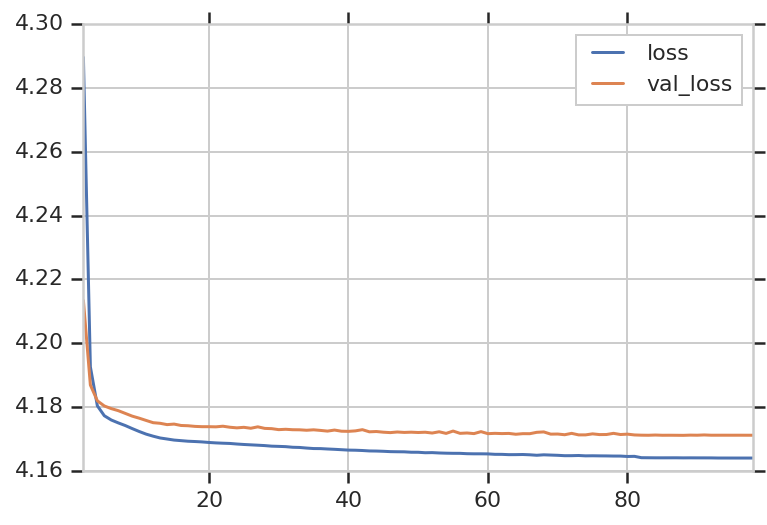

In [0]:
pd.DataFrame(history)[['loss', 'val_loss']][2:].plot()

### Eval

In [0]:
if LOSS == 'mse':
  y_pred = model.predict(x=x_eval, batch_size=1024).flatten()

if LOSS == 'ziln':
  logits = model.predict(x=x_eval, batch_size=1024)
  y_pred = ltv.zero_inflated_lognormal_pred(logits).numpy().flatten()

In [0]:
df_pred = pd.DataFrame({
    'y_true': y_eval,
    'y_pred': y_pred,
})
df_pred.head(10)

,y_pred,y_true
0,18.185350,1.57
1,20.422848,23.16
2,240.908432,252.28
3,35.072281,5.49
4,47.286964,3.69
5,13.456080,2.48
6,31.121714,45.31
7,15.125760,30.95
8,21.852407,11.94
9,55.407394,40.55


### Gini Coefficient

In [0]:
gain = pd.DataFrame({
    'lorenz': ltv.cumulative_true(y_eval, y_eval),
    'baseline': ltv.cumulative_true(y_eval, y0_eval),
    'model': ltv.cumulative_true(y_eval, y_pred),
})

In [0]:
num_customers = np.float32(gain.shape[0])
gain['cumulative_customer'] = (np.arange(num_customers) + 1.) / num_customers

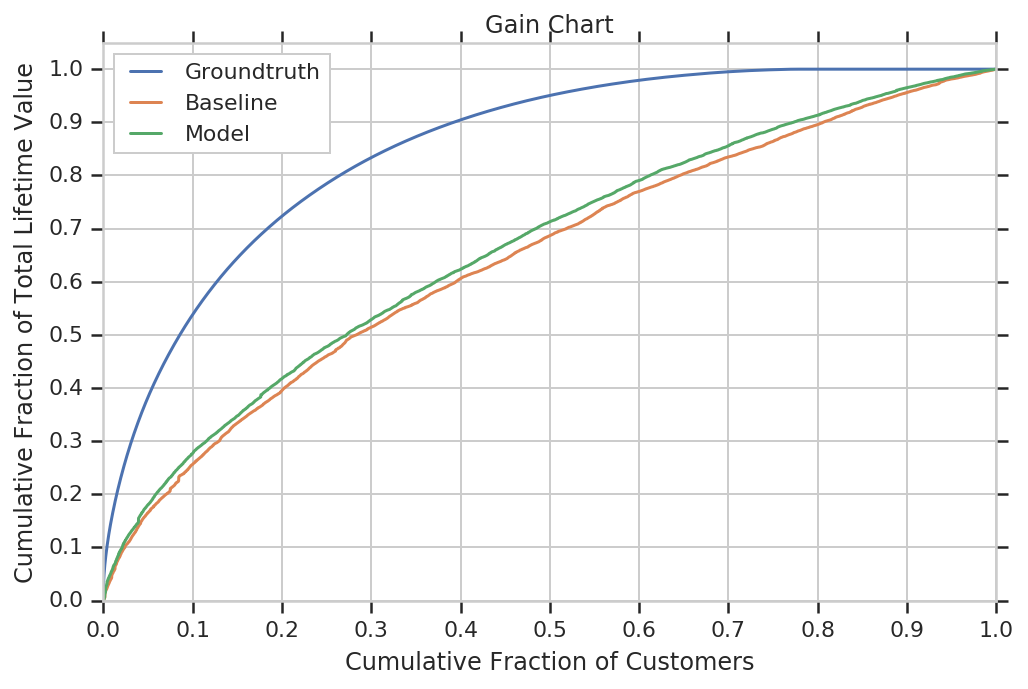

In [0]:
ax = gain[[
    'cumulative_customer',
    'lorenz',
    'baseline',
    'model',
]].plot(
    x='cumulative_customer', figsize=(8, 5), legend=True)

ax.legend(['Groundtruth', 'Baseline', 'Model'], loc='upper left')

ax.set_xlabel('Cumulative Fraction of Customers')
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_xlim((0, 1.))

ax.set_ylabel('Cumulative Fraction of Total Lifetime Value')
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylim((0, 1.05))
ax.set_title('Gain Chart')

In [0]:
gini = ltv.gini_from_gain(gain[['lorenz', 'baseline', 'model']])
gini

,raw,normalized
lorenz,0.706898,1.000000
baseline,0.290024,0.410277
model,0.325384,0.460298


### Calibration

In [0]:
df_decile = ltv.decile_stats(y_eval, y_pred)
df_decile

,label_mean,normalized_mae,normalized_rmse,pred_mean,decile_mape
decile,,,,,
0,13.681039,1.113830,2.491969,12.661569,0.074517
1,20.310737,1.056633,2.121411,19.333267,0.048126
2,22.728945,1.040487,1.855777,23.199310,0.020695
3,25.441446,1.036384,1.613740,27.419205,0.077738
4,30.961781,0.981437,1.713931,31.107035,0.004691
5,35.221345,0.984319,1.686755,35.173012,0.001372
6,37.128378,0.998047,1.819248,39.990730,0.077093
7,43.696324,0.978155,1.530850,47.477573,0.086535
8,55.142434,0.986490,2.435485,61.094627,0.107942


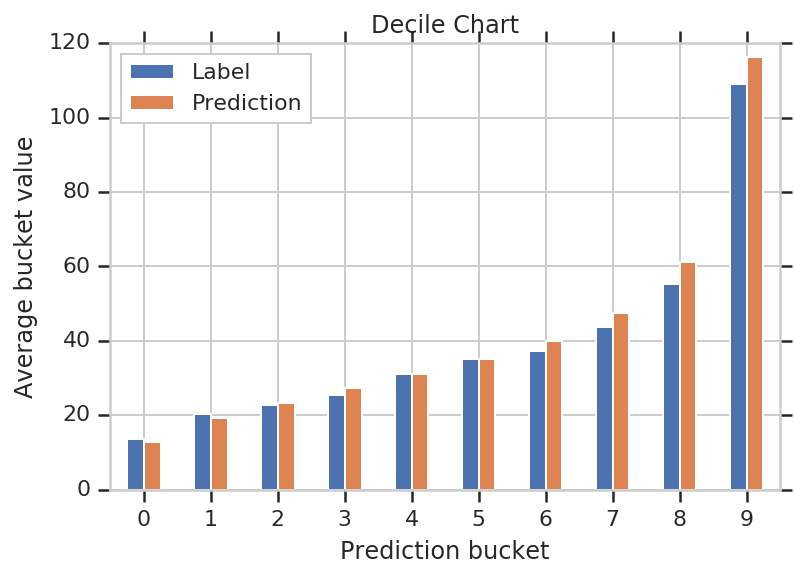

In [0]:
ax = df_decile[['label_mean', 'pred_mean']].plot.bar(rot=0)

ax.set_title('Decile Chart')
ax.set_xlabel('Prediction bucket')
ax.set_ylabel('Average bucket value')
ax.legend(['Label', 'Prediction'], loc='upper left')

### Rank Correlation

In [0]:
def spearmanr(x1: Sequence[float], x2: Sequence[float]) -> float:
  """Calculates spearmanr rank correlation coefficient.

  See https://docs.scipy.org/doc/scipy/reference/stats.html.

  Args:
    x1: 1D array_like.
    x2: 1D array_like.

  Returns:
    correlation: float.
  """
  return stats.spearmanr(x1, x2, nan_policy='raise')[0]


spearman_corr = spearmanr(y_eval, y_pred)
spearman_corr

0.31160782761223393

### All metrics together

In [0]:
df_metrics = pd.DataFrame(
    {
        'company': COMPANY,
        'model': MODEL,
        'loss': LOSS,
        'label_mean': y_eval.mean(),
        'pred_mean': y_pred.mean(),
        'label_positive': np.mean(y_eval > 0),
        'decile_mape': df_decile['decile_mape'].mean(),
        'baseline_gini': gini['normalized'][1],
        'gini': gini['normalized'][2],
        'spearman_corr': spearman_corr,
    },
    index=[0])

In [0]:
df_metrics[[
    'company',
    'model',
    'loss',
    'label_mean',
    'pred_mean',
    'label_positive',
    'decile_mape',
    'baseline_gini',
    'gini',
    'spearman_corr',
]]

,company,model,loss,label_mean,pred_mean,label_positive,decile_mape,baseline_gini,gini,spearman_corr
0,103600030,dnn,ziln,39.295242,41.35421,0.774563,0.0567,0.410277,0.460298,0.311608


## Save

In [0]:
output_path = os.path.join(OUTPUT_CSV_FOLDER, COMPANY)

In [0]:
if not os.path.isdir(output_path):
  os.makedirs(output_path)

In [0]:
output_file = os.path.join(output_path,
                           '{}_regression_{}.csv'.format(MODEL, LOSS))

In [0]:
df_metrics.to_csv(output_file, index=False)